# Распознавание ключевых слов: использование речевых формант в качестве входных параметров модели 

Пример ноутбука, распознающего слова "down", "go", "left", "no", "right", "stop", "up", "yes", используя форманты в качестве фичей

## Установка библиотек

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn import preprocessing as skl_prepr

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from scipy.signal import find_peaks
from scipy.signal import welch

import python_speech_features as psf

from pydub import AudioSegment

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
print(tf.__version__, np.__version__)

2.7.0 1.19.5


## Импорт датасета Google Speech Commands

Используется малый датасет для настройки алгоритма

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Shuffle файлов

In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames, seed = seed)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\right\\ab00c4b2_nohash_0.wav', shape=(), dtype=string)


Train/test/validate-split

In [7]:
train_ex = 6400
test_ex = 800
val_ex = 800

train_files = filenames[:train_ex]
val_files = filenames[train_ex : train_ex + test_ex]
test_files = filenames[train_ex + test_ex : train_ex + test_ex + val_ex]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Заливка аудиофайлов

In [8]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

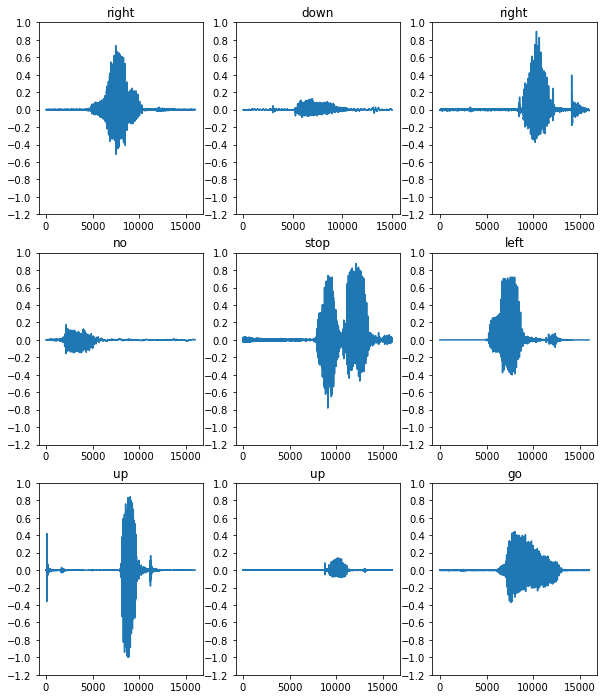

In [12]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Спектрограммы

Блок с исследованием спектрограмм сигналов

In [189]:
stft_frame_length = 512
stft_frame_step = (stft_frame_length + 1) // 2
stft_fft_length = 129
peak_diff = 3
print(stft_frame_length, stft_frame_step, stft_fft_length)

512 256 129


In [190]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=stft_frame_length, 
      frame_step=stft_frame_step, fft_length=stft_fft_length,
      window_fn=tf.signal.hann_window)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [192]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (61, 65, 1)
Audio playback


In [193]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  #print(spectrogram.shape)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

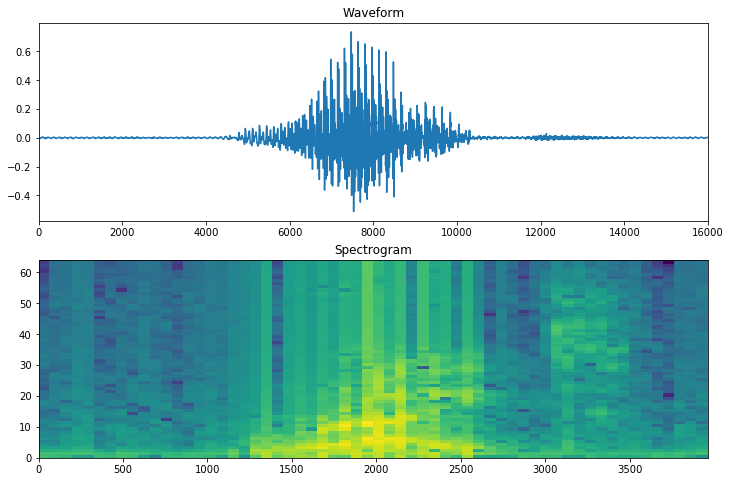

In [194]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [195]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [196]:
formant_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Спектрограммы различных сигналов + паддинг

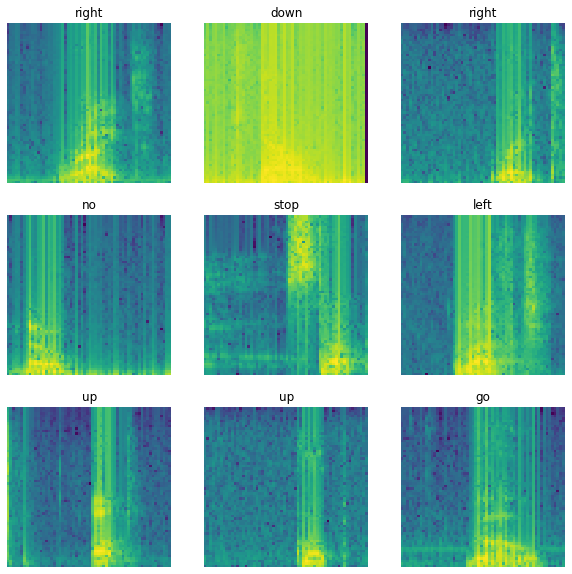

In [197]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(formant_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Извлечение фичей
Из полученных STFT выбираются три максимальных пика. Далее из всего вектора STFT извлекаются окрестности пиков, остальные параметры зануляются - подготовленный вектор отправляется на вход нейронной сети

In [198]:
def get_fourier(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    wave_stft = tf.signal.stft(
        equal_length, frame_length=stft_frame_length, 
        frame_step=stft_frame_step, fft_length = stft_fft_length,
        window_fn = tf.signal.hann_window)
    wave_stft = tf.abs(wave_stft)
    wave_stft = wave_stft[..., tf.newaxis]
    return wave_stft

In [199]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  feat_ = get_fourier(waveform)
  print(label, feat_.shape)

right (61, 65, 1)


[ 1  6  8 11 18 21 24 26 30 33 36 38 40 42 44 49 54 58 62] (19,) 
 [2.14637443e-03 1.43872364e-03 2.43057264e-04 5.23256487e-04
 1.81550294e-03 9.71501577e-05 1.08189095e-04 1.96100969e-04
 3.21220956e-04 1.22864809e-03 3.86451720e-05 3.21024854e-04
 5.07823424e-05 2.09700549e-04 1.38731673e-04 1.74799337e-04
 1.88538266e-04 1.69588020e-05 5.60103836e-05] shape:  (19,) 
 [ 6 18  1] (3,)


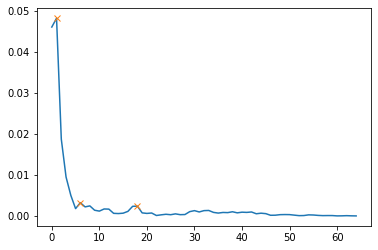

In [200]:
x = feat_[:1].numpy().flatten()
peaks, properties = find_peaks(x, height=0, prominence = 0)
print(peaks, peaks.shape,  '\n', properties['prominences'], 'shape: ',  properties['prominences'].flatten().shape , '\n', 
    peaks[np.argsort(properties['prominences'])[-3:]], peaks[np.argsort(properties['prominences'])[-3:]].shape)
plt.plot(x)
plt.plot(peaks[np.argsort(properties['prominences'])[-3:]], x[peaks[np.argsort(properties['prominences'])[-3:]]], "x")
plt.show()

In [201]:
def local_extract_peaks_prom(arr):
    peaks, properties = find_peaks(arr, height = 0, prominence = 0)
    
    arr_inp = np.zeros(arr.shape[0])
    ind_pr = peaks[np.argsort(properties['prominences'])[-3:]]

    arr_inp.put(peaks, arr[ind_pr], mode = 'clip')


    ind_full = list(ind_pr)

    for i in ind_pr:
        # print(i)
        for k in range(-peak_diff, peak_diff + 1):
            if k != 0 and i + k >= 0 and i + k < arr.shape[0] - 1:
                ind_full.append(i + k)
    arr_out = np.zeros(arr.shape)
    arr_out.put(ind_full, arr[ind_full], mode = 'clip')
    return arr_out, ind_pr


Иллюстрация разметки пиков

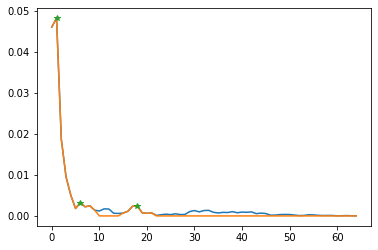

In [202]:
z = feat_[:1].numpy().flatten()
x, ind = local_extract_peaks_prom(z)
plt.plot(z)
plt.plot(x)
plt.plot(ind, x[ind], "*")
plt.show()

In [203]:
def filter_peaks_stft(arr):
    arr_, _ = local_extract_peaks_prom(arr)
    return arr_

In [204]:
def filter_peaks_stft_apply(waveform, label):
    inp_arr = waveform.numpy()
    features_init = get_fourier(waveform)
    features = tf.convert_to_tensor(np.apply_along_axis(filter_peaks_stft, 1, features_init), dtype=tf.float32)
    
    label_id = tf.argmax(label == commands)
    #print('label_id : ', label_id, ' features : ', features.shape)
    del inp_arr

    return features, label_id

In [205]:
i = 0
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  i = i + 1
  label = label.numpy().decode('utf-8')
  f_, l_ = filter_peaks_stft_apply(waveform, label)

shape_res = f_.shape

In [206]:
def filter_peaks_stft_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = filter_peaks_stft_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = tf.reshape(wv, shape=(shape_res[0] * shape_res[1],))
    return wv, lbl


In [207]:
for waveform, label in files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE).take(1):
  wv, label_ = filter_peaks_stft_outside_function(waveform, label)
  print(wv.shape, label_)

(3965,) tf.Tensor(4, shape=(), dtype=int64)


In [208]:
def filter_peaks_stft_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(filter_peaks_stft_outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [209]:
train_ds = filter_peaks_stft_preprocess_dataset(train_files)
val_ds = filter_peaks_stft_preprocess_dataset(val_files)
test_ds = filter_peaks_stft_preprocess_dataset(test_files)

whole_ds = filter_peaks_stft_preprocess_dataset(filenames)

In [210]:
def plot_filtered_stft(features, ax):
  features = tf.reshape(features, shape = (shape_res[0], shape_res[1], 1))
  if len(features.shape) > 2:
    assert len(features.shape) == 3
    features = np.squeeze(features, axis=-1)
  log_feat = np.log(features.T + np.finfo(float).eps)
  height = log_feat.shape[0]
  width = log_feat.shape[1]
  X = np.linspace(0, np.size(features), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_feat)

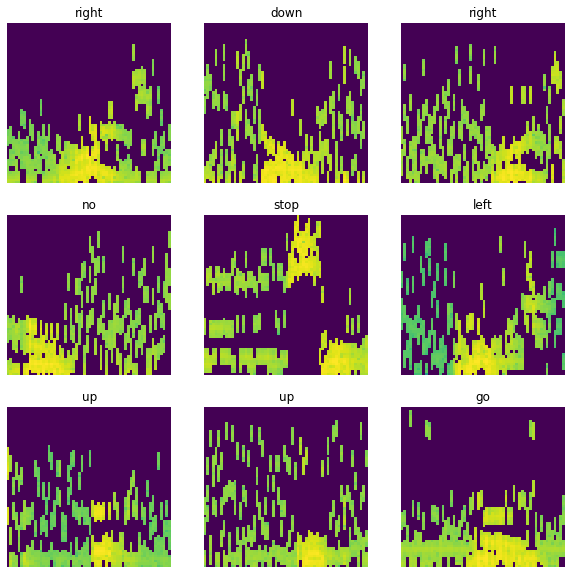

In [211]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (features, label_id) in enumerate(whole_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_filtered_stft(features.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [212]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [213]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
print(train_ds.take(1))

<TakeDataset shapes: ((None, 3965), <unknown>), types: (tf.float32, tf.int64)>


### Инициализация и обучение модели (Full Dense-NN) над отфильтрованными STFT

Размерность входного слоя - 129 * 124 (размерность STFT x количество окон)

In [214]:
for elem, _ in whole_ds.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (3965,)
8


In [215]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(256, activation='relu', name = 'dense_256'),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu', name = 'dense_128_2'),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu', name = 'dense_64'),
    layers.Dropout(0.1),
    layers.Dense(num_labels, activation = 'softmax', name = 'softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 256)               1015296   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_128_2 (Dense)         (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 softmax (Dense)             (None, 8)                

In [216]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [217]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 93s 916ms/step - loss: 1.9712 - sparse_categorical_accuracy: 0.3070 - val_loss: 1.8605 - val_sparse_categorical_accuracy: 0.4250
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 1.8364 - sparse_categorical_accuracy: 0.4525 - val_loss: 1.7765 - val_sparse_categorical_accuracy: 0.5263
Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 1.7583 - sparse_categorical_accuracy: 0.5289 - val_loss: 1.7115 - val_sparse_categorical_accuracy: 0.5738
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 1.7041 - sparse_categorical_accuracy: 0.5853 - val_loss: 1.6972 - val_sparse_categorical_accuracy: 0.5900
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 1.6594 - sparse_categorical_accuracy: 0.6283 - val_loss: 1.6880 - val_sparse_categorical_accuracy: 0.5962
Epoch 6/10
100/100 [==============================] - 1s 9ms/step - loss: 1.6285 - sparse_categ

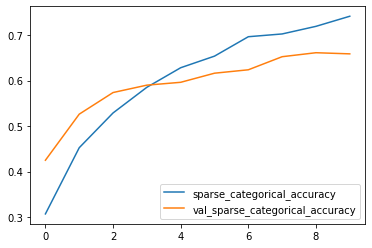

In [218]:
metrics = history.history
plt.plot(history.epoch, metrics['sparse_categorical_accuracy'], metrics['val_sparse_categorical_accuracy'])
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
plt.show()

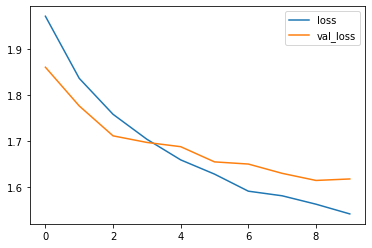

In [219]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Тестирование

In [220]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [221]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 67%


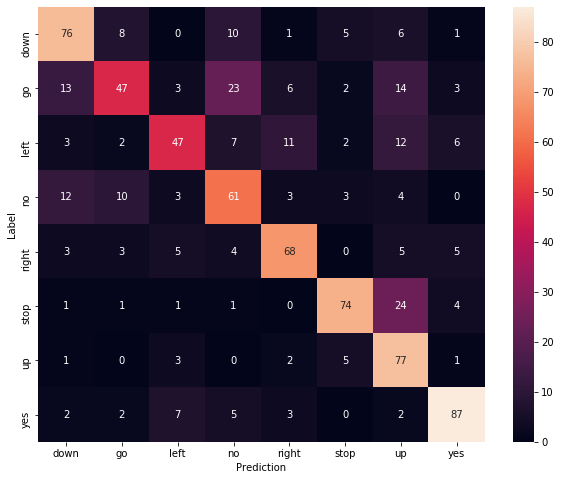

In [222]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

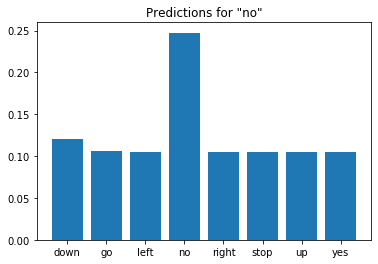

In [223]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = filter_peaks_stft_preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

### Сверточная сеть над изображениями

In [224]:
def filter_peaks2d_stft_outside_function(waveform, label):
    wv, lbl = tf.py_function(func = filter_peaks_stft_apply, inp = [waveform, label], Tout = [tf.float32, tf.int64])
    wv = wv[..., tf.newaxis]
    wv = tf.reshape(wv, shape = (shape_res))
    return wv, lbl


In [225]:
def filter_peaks2d_stft_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label)
  output_ds = output_ds.map(filter_peaks2d_stft_outside_function)
  #output_ds = output_ds.map(fix_shape_)
  return output_ds

In [226]:
train_ds_2d = filter_peaks2d_stft_preprocess_dataset(train_files)
val_ds_2d = filter_peaks2d_stft_preprocess_dataset(val_files)
test_ds_2d = filter_peaks2d_stft_preprocess_dataset(test_files)

whole_ds_2d = filter_peaks2d_stft_preprocess_dataset(filenames)

In [227]:
batch_size = 64
train_ds_2d = train_ds_2d.batch(batch_size)
val_ds_2d = val_ds_2d.batch(batch_size)

In [228]:
train_ds_2d = train_ds_2d.cache().prefetch(AUTOTUNE)
val_ds_2d = val_ds_2d.cache().prefetch(AUTOTUNE)
print(train_ds_2d.take(1))

<TakeDataset shapes: ((None, 61, 65, 1), <unknown>), types: (tf.float32, tf.int64)>


In [229]:
for elem, _ in whole_ds_2d.take(1):
  input_shape = elem.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

Input shape: (61, 65, 1)
8


In [230]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=whole_ds_2d.map(map_func=lambda spec, label: spec))

In [231]:
model_2d = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(4, 16, activation='relu'),
    layers.Conv2D(16, 16, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_2d.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 50, 4)         1028      
                                                                 
 conv2d_5 (Conv2D)           (None, 31, 35, 16)        16400     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 17, 16)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 15, 17, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 4080)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               522368    
                                                      

In [232]:
model_2d.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [233]:
EPOCHS = 10
history = model_2d.fit(
    train_ds_2d, 
    validation_data=val_ds_2d,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 144s 1s/step - loss: 1.8343 - sparse_categorical_accuracy: 0.3252 - val_loss: 1.4423 - val_sparse_categorical_accuracy: 0.5238
Epoch 2/10
100/100 [==============================] - 40s 402ms/step - loss: 1.3418 - sparse_categorical_accuracy: 0.5403 - val_loss: 1.0717 - val_sparse_categorical_accuracy: 0.6413
Epoch 3/10
100/100 [==============================] - 40s 400ms/step - loss: 1.1043 - sparse_categorical_accuracy: 0.6130 - val_loss: 0.9617 - val_sparse_categorical_accuracy: 0.6637
Epoch 4/10
100/100 [==============================] - 40s 400ms/step - loss: 0.9616 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.8690 - val_sparse_categorical_accuracy: 0.6963
Epoch 5/10
100/100 [==============================] - 40s 402ms/step - loss: 0.8697 - sparse_categorical_accuracy: 0.6952 - val_loss: 0.7856 - val_sparse_categorical_accuracy: 0.7212
Epoch 6/10
100/100 [==============================] - 43s 432ms/step - loss: 0.8128 - s

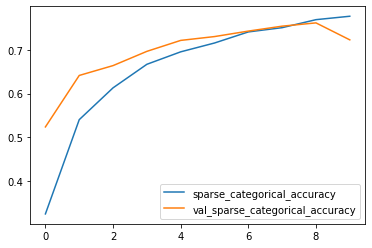

In [234]:
metrics = history.history
plt.plot(history.epoch, metrics['sparse_categorical_accuracy'], metrics['val_sparse_categorical_accuracy'])
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
plt.show()

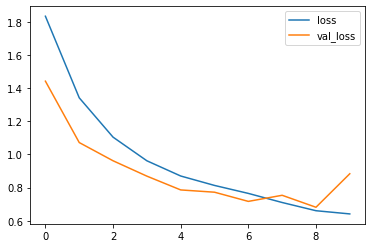

In [235]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [236]:
test_audio = []
test_labels = []

for audio, label in test_ds_2d:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [237]:
y_pred = np.argmax(model_2d.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 79%


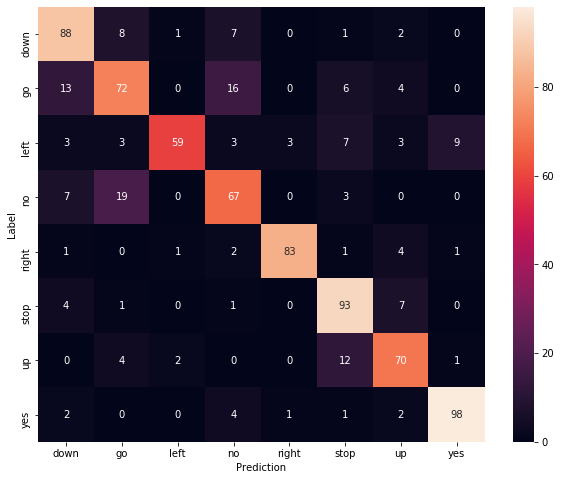

In [238]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()